*You are provided with historical sales data for 45 Walmart stores located in different regions.*
*Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.*

Data Description https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data


In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
root = Path('/home/anvar/walmart/walmart-recruiting-store-sales-forecasting/')

list(root.glob('*.csv'))

[PosixPath('/home/anvar/walmart/walmart-recruiting-store-sales-forecasting/test.csv'),
 PosixPath('/home/anvar/walmart/walmart-recruiting-store-sales-forecasting/stores.csv'),
 PosixPath('/home/anvar/walmart/walmart-recruiting-store-sales-forecasting/features.csv'),
 PosixPath('/home/anvar/walmart/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv'),
 PosixPath('/home/anvar/walmart/walmart-recruiting-store-sales-forecasting/train.csv')]

In [3]:
train = pd.read_csv(root / 'train.csv')

In [4]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
train.Dept.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56,
       58, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90,
       91, 92, 93, 94, 95, 96, 97, 98, 99, 39, 50, 43, 65])

In [6]:
train.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [7]:
train_stores = train.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()

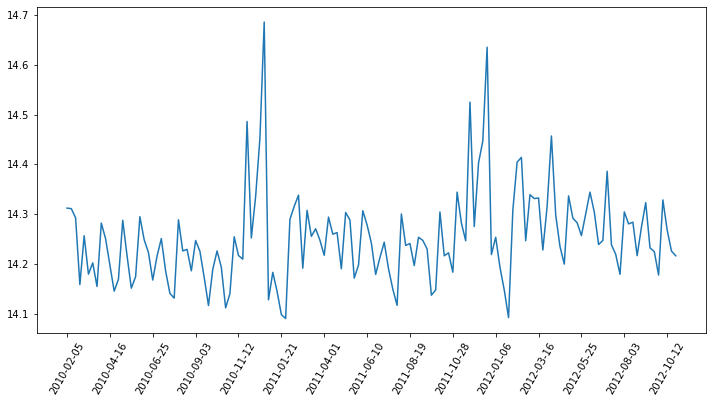

In [8]:
x = train_stores.query('Store==1')[['Date','Weekly_Sales']]

plt.figure(figsize=(12,6))
plt.plot(x.Date,
        np.log(x.Weekly_Sales));
plt.xticks(ticks=x.Date[::10], rotation=60);

In [9]:
x.Date = pd.to_datetime(x.Date)
x['year'] = pd.DatetimeIndex(x.Date).year
x['month'] = pd.DatetimeIndex(x.Date).month

In [10]:
x.groupby([x.year, x.month])['Weekly_Sales'].sum()

year  month
2010  2        6307344.10
      3        5871293.98
      4        7422801.92
      5        5929938.64
      6        6084081.46
      7        7244483.04
      8        6075952.95
      9        5829793.92
      10       7150641.75
      11       6485547.06
      12       8876953.18
2011  1        5480050.97
      2        6399887.57
      3        6307375.48
      4        7689123.60
      5        6128431.80
      6        6194971.74
      7        7227654.31
      8        6144985.73
      9        7379542.34
      10       6072327.75
      11       6864972.83
      12       9032594.71
2012  1        5723690.52
      2        6798074.91
      3        8201997.40
      4        6511214.82
      5        6446962.46
      6        8020582.84
      7        6233946.67
      8        7897619.59
      9        6122381.52
      10       6245587.29
Name: Weekly_Sales, dtype: float64

# Another Store

In [11]:
train_stores.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

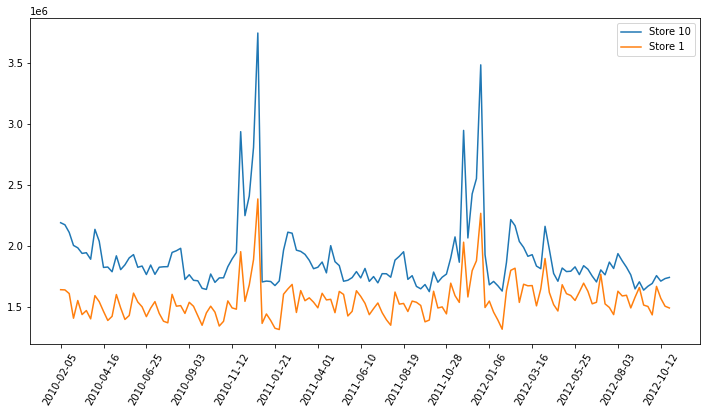

In [12]:
i = 10
x = train_stores.query('Store==1')[['Date','Weekly_Sales']]
x2 = train_stores.query('Store==@i')[['Date','Weekly_Sales']]

plt.figure(figsize=(12,6))
plt.plot(x2.Date,
        x2.Weekly_Sales, label=f'Store {i}');
plt.plot(x.Date,
        x.Weekly_Sales, label='Store 1');

plt.legend()
plt.xticks(ticks=x2.Date[::10], rotation=60);

In [13]:
x.index = x.Date

# Train a simple model

Features are lags: What was the value of TS x timesteps ago?

In [14]:
def generate_features(x, start_lag=8, end_lag=48, test=False):
        
    X = pd.DataFrame(index=x.index)
    for i in range(start_lag, end_lag):
        X['lag_{}'.format(i)] = x['Weekly_Sales'].shift(i)
        
    if test:
        return X.dropna()
    
    X['y'] = x['Weekly_Sales']
    return X.dropna()

In [15]:
X_train = generate_features(x)

In [16]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
model = RandomForestRegressor(n_estimators=30, max_depth=20, min_samples_split=5)

In [18]:
model.fit(X_train.drop('y', axis=1), X_train['y'])

RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=30)

In [19]:
y_pred = model.predict(X_train.drop('y', axis=1))

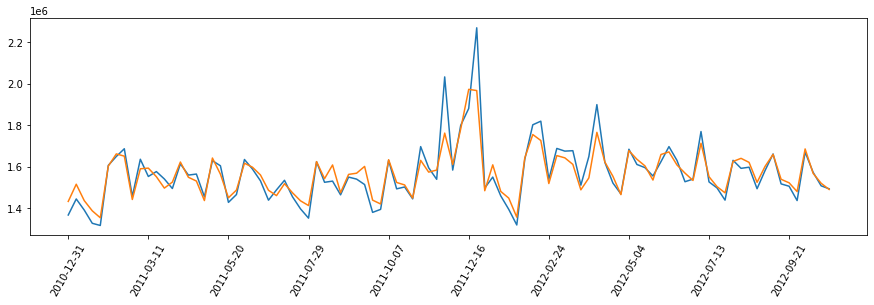

In [20]:
plt.figure(figsize=(15,4))
plt.plot(X_train.index, X_train['y'])
plt.plot(X_train.index, y_pred)
plt.xticks(ticks=X_train.index[::10], rotation=60);

# Split data on train and test

In [21]:
x_train = x.truncate(after='2012-01-01')
x_test= x.truncate(before='2012-01-01')

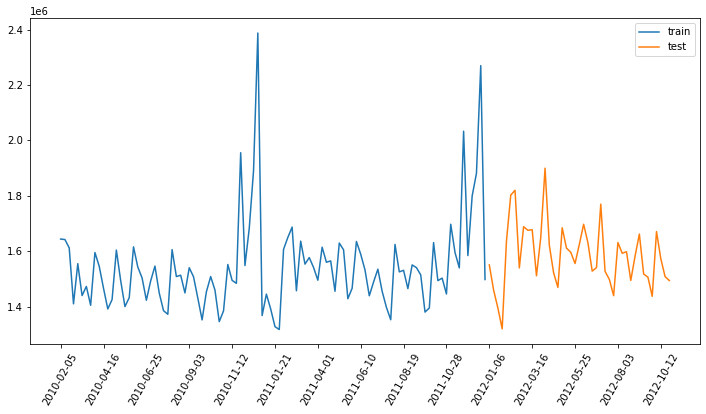

In [22]:
plt.figure(figsize=(12,6))
plt.plot(x_train.Date,
        x_train.Weekly_Sales, label=f'train');
plt.plot(x_test.Date,
        x_test.Weekly_Sales, label='test');

plt.legend()
plt.xticks(ticks=x.Date[::10], rotation=60);

# Baseline predict sales by sales year ago

In [23]:
from sklearn.metrics import mean_squared_error

In [24]:
index_test = x_test.index
X = pd.DataFrame(index=x.index)
X['sales'] = x['Weekly_Sales'].shift(52)
X['Weekly_Sales'] = x['Weekly_Sales']
X.dropna(inplace=True)
X = X.loc[index_test]

np.sqrt(mean_squared_error(X['Weekly_Sales'],X['sales']))

97900.47416303726

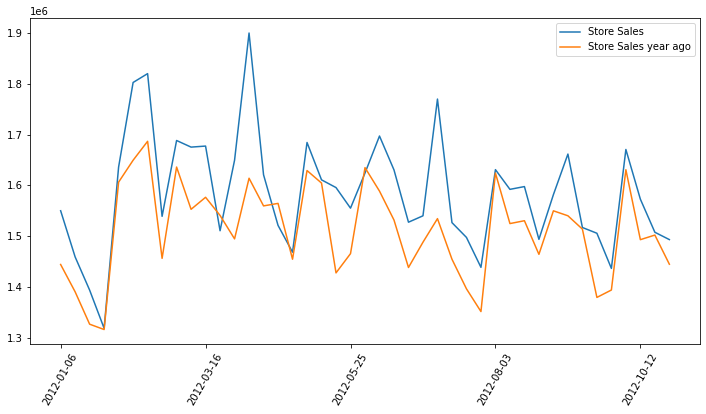

In [25]:
plt.figure(figsize=(12,6))
plt.plot(X.index,
        X.Weekly_Sales, label=f'Store Sales');
plt.plot(X.index,
        X.sales, label='Store Sales year ago');

plt.legend()
plt.xticks(ticks=X.index[::10], rotation=60);

# RF on lag features

In [26]:
def generate_features(x, x_test=None, start_lag=8, end_lag=48):
    
    if x_test is not None:
        index_test = x_test.index
        x = pd.concat([x, x_test])
        
    X = pd.DataFrame(index=x.index)
    for i in range(start_lag, end_lag):
        X['lag_{}'.format(i)] = x['Weekly_Sales'].shift(i)
        
    X['y'] = x['Weekly_Sales']
    
    if x_test is not None:
        return X.loc[index_test]
    return X.dropna()

In [27]:
X_train = generate_features(x_train)
X_test = generate_features(x_train, x_test)

In [28]:
random_state=19

In [29]:
model = RandomForestRegressor(n_estimators=30, max_depth=20, min_samples_split=5, random_state=random_state)

In [30]:
model.fit(X_train.drop('y', axis=1), X_train['y'])

RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=30,
                      random_state=19)

In [31]:
y_pred_test = model.predict(X_test.drop('y', axis=1))

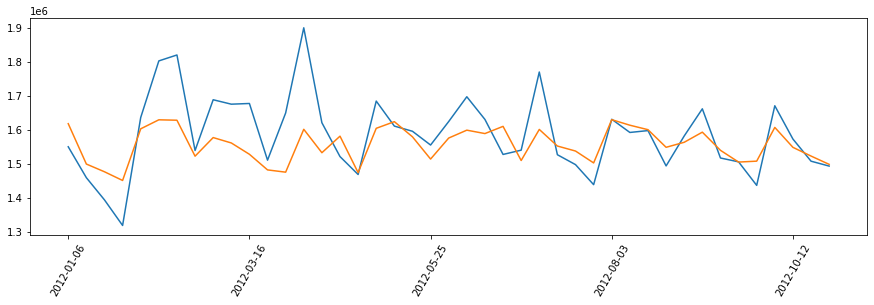

In [32]:
plt.figure(figsize=(15,4))
plt.plot(X_test.index, X_test['y'])
plt.plot(X_test.index, y_pred_test)
plt.xticks(ticks=X_test.index[::10], rotation=60);

In [33]:
np.sqrt(mean_squared_error(X_test['y'], y_pred_test))

91598.78915103716

In [34]:
X_test['y'].mean()

1586094.3725581395

# Add more features: rolling mean, diff, lin-reg

In [35]:
def lin_reg(X):
    n = X.shape[0]
    x = np.concatenate((np.ones(n),
                        np.arange(n)),
                      ).reshape(2, n).T
    
    y = X.reshape(-1,1)
    theta = np.linalg.pinv(x.dot(x.T)).dot(x).T.dot(y)

    return np.array([[1, n]]).dot(theta)

In [36]:
def generate_features(x, x_test=None, start_lag=8, end_lag=48):
    
    if x_test is not None:
        index_test = x_test.index
        x = pd.concat([x, x_test])
        
    X = pd.DataFrame(index=x.index)
    # Lags
    for i in range(start_lag, end_lag, 2):
        X[f'lag_{i}'] = x['Weekly_Sales'].shift(i)
        
    # Diff
    for i in range(start_lag, end_lag, 12):
        X[f'diff_{i}_1'] = x['Weekly_Sales'].shift(i).diff(1)
    
    # Mean
    for i in range(start_lag, end_lag, 12):
        X[f'mean_{i}_2'] = x['Weekly_Sales'].shift(i).rolling(window=5).mean()
        
    X['y'] = x['Weekly_Sales']
    
    if x_test is not None:
        return X.loc[index_test]
    return X.dropna()

In [37]:
X_train = generate_features(x_train)
X_test = generate_features(x_train, x_test)

In [38]:
model = RandomForestRegressor(n_estimators=30, max_depth=20, min_samples_split=5, random_state=random_state)

In [39]:
model.fit(X_train.drop('y', axis=1), X_train['y'])

RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=30,
                      random_state=19)

In [40]:
y_pred_test = model.predict(X_test.drop('y', axis=1))

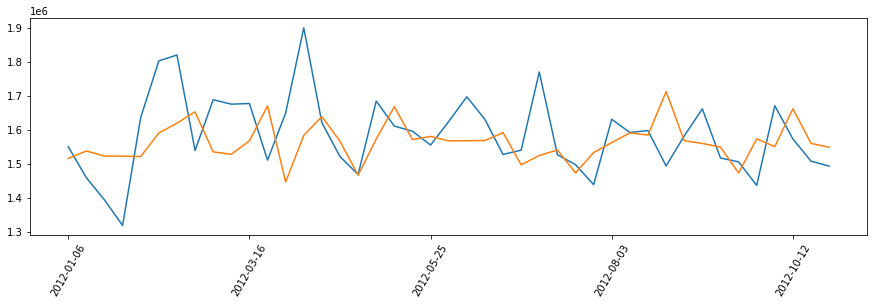

In [41]:
plt.figure(figsize=(15,4))
plt.plot(X_test.index, X_test['y'])
plt.plot(X_test.index, y_pred_test)
plt.xticks(ticks=X_test.index[::10], rotation=60);

In [42]:
np.sqrt(mean_squared_error(X_test['y'], y_pred_test))

121067.7418458479

# Let's try something else, normalize Y

In [43]:
model = RandomForestRegressor(n_estimators=30, max_depth=20, min_samples_split=5, random_state=random_state)
model.fit(X_train.drop('y', axis=1), np.log(X_train['y']))

RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=30,
                      random_state=19)

In [44]:
y_pred_test = np.exp(model.predict(X_test.drop('y', axis=1)))

In [45]:
np.sqrt(mean_squared_error(X_test['y'], y_pred_test))

121286.84599068391

# Now let's add some features

In [46]:
stores = pd.read_csv(root / 'stores.csv')
features = pd.read_csv(root / 'features.csv')

In [47]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [48]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


# Join all data

In [49]:
train_data = pd.merge(train, stores, on='Store')
train_data = pd.merge(train_data, features, on=['Store', 'Date'])\
               .drop('IsHoliday_y', axis=1)\
               .rename(columns={'IsHoliday_x': 'Is_Holiday'})

In [50]:
train_data

,Store,Dept,Date,Weekly_Sales,Is_Holiday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
421566,45,94,2012-10-26,5203.31,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
421567,45,95,2012-10-26,56017.47,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
421568,45,97,2012-10-26,6817.48,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667


## Ideas for features

You could compute different aggregates:

1. Weekly_Sales over Stores with the same Type, at the same Month/Week
2. Average/Min/Max Temperature for each week
3. Adjust for Fuel_Price: for a given Store what was Weekly_Sales of other Stores with about the same Fuel_Price?
4. Correct on Unemployment: for each Store and week Flag if Unemployment goes down or up since some time stemp
5. Normalize Weekly_Sales on Size of a Store
6. Average Fuel_Price over the last week/month/season
7. Is this week a Holiday or not
8. ...

In [51]:
test = pd.read_csv(root / 'test.csv')

In [52]:
test

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False
